# Sparkify Project Refinement

This notebook contains the refinement of modeling for medium sized dataset.

The overview of the project and data anaylsis is presented in Sparkify.ipynb notebook.

## Prepare Data

Scripts for data processing were described in Sparkify.ipynb notebook:

In [1]:
# import general libraries for data manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import re

In [2]:
# import spark libraries
from pyspark.sql import SparkSession

from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, OneHotEncoderEstimator
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType, DateType
from pyspark.sql.functions import to_date, datediff
from pyspark.sql.functions import concat, lit, avg, split, isnan, when, count, col, sum, mean, stddev, min, max, round
from pyspark.sql import Window

from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import Bucketizer

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

In [4]:
df = spark.read.json('medium-sparkify-event-data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
def clean_data(df):
    '''
    Function which performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify log events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column
    '''
    
    # remove rows where userId is empty
    df_new = df.filter(df["userId"] != "")
    
    return df_new

# clean data
df = clean_data(df)

# print out first line
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

In [8]:
def prepare_dataset(df):
    '''
    Function for preparation of dataset for machine learning
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning
    contains the following columns:
    1. userId - initial id of the user
    2. gender - user's gender
    3. avg_events - average number of events per day for the user
    4. avg_songs - average number of songs the user listens to per day
    5. thumbs_up - number of thumbs up events
    6. thumbs_down - number of thumbs down events
    7. active_days - days since user's firts event
    8. last_location - location of the last event
    9. last_level - user's last level (paid or free)
    10. addfriends - number of add friends events
    '''
    
    # clean dataset using clean_data function
    df = clean_data(df)
    
    # add 'churn' column to the original dataset
    
    # define cancellation udf
    cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    
    # set churn = 1 for rows where page == 'Cancellation Confirmation'
    df = df.withColumn("churn", cancellation_event("page"))
    
    # get userId with churn == 1
    cancelled_users = df.select(['userId']).where(df.churn == 1).groupby('userId').count().toPandas()['userId'].values
    
    # create udf, which sets churn of a row to 1 if userId is in cancelled_users list
    def fill_array(userId, features):
        if(userId in cancelled_users): return 1
        else : return 0
    
    # set churn == 1 for all rows for users who cancelled their subscription
    fill_array_udf = udf(fill_array, IntegerType())
    df = df.withColumn("churn", fill_array_udf(col("userId"), col("churn")))
    
    # set column last ts with the first and the last event timestamp
    w = Window.partitionBy('userId')
    df = df.withColumn('last_ts', max('ts').over(w))
    df = df.withColumn('first_ts', min('ts').over(w))
    
    # convert timestamp to date (string)
    def get_date_from_ts(ts):
        return str(datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d'))
    
    get_date_from_ts_udf = udf(get_date_from_ts, StringType())
    df = df.withColumn('last_date', get_date_from_ts_udf(col('last_ts')))
    df = df.withColumn('first_date', get_date_from_ts_udf(col('first_ts')))
    
    # add column date and convert timetamp to date
    df = df.withColumn('date', get_date_from_ts_udf(col('ts')))
    
    # set column last_level to level when timestamp is last timestamp
    df = df.withColumn('last_level',when(df.last_ts == df.ts, df.level))
    
    # create column avg_songs to calculate average number of songs per day
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs', avg('songs').over(w))
    songs = songs.select(col("userId").alias("songs_userId"), 'avg_songs')
    songs = songs.withColumn("avg_songs", round(songs["avg_songs"], 2))
    
    # create column avg_songs to calculate average number of events per day
    w = Window.partitionBy('userId', 'date')
    events = df.select('userId', 'date', count('userId').over(w).alias('events')).distinct()
    w = Window.partitionBy('userId')
    events = events.withColumn('avg_events', avg('events').over(w))
    events = events.select(col("userId").alias("events_userId"), 'avg_events')
    events = events.withColumn("avg_events", round(events["avg_events"], 2))
    
    # calculate number of thumbs up for a user
    w = Window.partitionBy('userId')
    thumbsup = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbsup = thumbsup.select(col("userId").alias("thumbsup_userId"), 'thumbs_up')
    
    # calculate number of thumbs down for a user
    w = Window.partitionBy('userId')
    thumbsdown = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbsdown = thumbsdown.select(col("userId").alias("thumbsdown_userId"), 'thumbs_down')
    
    # calculate days since the date of the first event
    df = df.withColumn("days_active", 
              datediff(to_date(lit(datetime.now().strftime("%Y-%m-%d %H:%M"))),
                       to_date("first_date","yyyy-MM-dd")))
    
    # add column with state of the event based on location column
    def get_state(location):
        location = location.split(',')[-1].strip()
        if (len(location) > 2):
            location = location.split('-')[-1].strip()
    
        return location
    
    get_state_udf = udf(get_state, StringType())
    df = df.withColumn('state', get_state_udf(col('location')))
    
    #add column with last location of the user
    df = df.withColumn('last_state',when(df.last_ts == df.ts, df.state))
    
    # calculate number of add friends for a user
    w = Window.partitionBy('userId')
    addfriend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('addfriend')).distinct()
    addfriend = addfriend.select(col("userId").alias("addfriend_userId"), 'addfriend')

    # assemble everything into resulting dataset
    df_ml = df.select('userId', 'gender', 'churn', 'last_level', 'days_active', 'last_state')\
    .dropna().drop_duplicates()
    df_ml = df_ml.join(songs, df_ml.userId == songs.songs_userId).distinct()
    df_ml = df_ml.join(events, df_ml.userId == events.events_userId).distinct()
    df_ml = df_ml.join(thumbsup, df_ml.userId == thumbsup.thumbsup_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_up'])
    df_ml = df_ml.join(thumbsdown, df_ml.userId == thumbsdown.thumbsdown_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_down'])
    df_ml = df_ml.join(addfriend, df_ml.userId == addfriend.addfriend_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['addfriend'])
    df_ml = df_ml.drop('songs_userId','events_userId', 'thumbsup_userId', 'thumbsdown_userId', 'addfriend_userId')
    
    return df, df_ml

In [9]:
df, df_ml = prepare_dataset(df)

In [10]:
df_ml.count()

448

In [11]:
df_ml.head(3)

[Row(userId='100010', gender='F', churn=1, last_level='free', days_active=189, last_state='CT', avg_songs=48.0, avg_events=68.5, thumbs_up=4, thumbs_down=3, addfriend=3),
 Row(userId='200002', gender='M', churn=1, last_level='paid', days_active=196, last_state='WI', avg_songs=51.67, avg_events=65.83, thumbs_up=15, thumbs_down=5, addfriend=2),
 Row(userId='296', gender='F', churn=1, last_level='paid', days_active=195, last_state='NJ', avg_songs=22.4, avg_events=30.4, thumbs_up=8, thumbs_down=0, addfriend=2)]

## Modeling

### Initial Preparation

Prepare train, test, and validation datasets:

In [14]:
# split into train, test and validation sets (60% - 20% - 20%)
df_ml = df_ml.withColumnRenamed("churn", "label")

train, test, valid = df_ml.randomSplit([0.6, 0.2, 0.2])

Prepare machine learning pipeline:

In [15]:
# index and encode categorical features gender, level and state

stringIndexerGender = StringIndexer(inputCol="gender", outputCol="genderIndex", handleInvalid = 'skip')
stringIndexerLevel = StringIndexer(inputCol="last_level", outputCol="levelIndex", handleInvalid = 'skip')
stringIndexerState = StringIndexer(inputCol="last_state", outputCol="stateIndex", handleInvalid = 'skip')

encoder = OneHotEncoderEstimator(inputCols=["genderIndex", "levelIndex", "stateIndex"],
                                       outputCols=["genderVec", "levelVec", "stateVec"],
                                handleInvalid = 'keep')

# create vector for features
features = ['genderVec', 'levelVec', 'stateVec', 'days_active', 'avg_songs', 'avg_events', 'thumbs_up', 'thumbs_down', 'addfriend']
assembler = VectorAssembler(inputCols=features, outputCol="features")

### Try Several Classifiers

`1` Random Forest Classifier:

In [27]:
# initialize random forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, rf])

In [28]:
model = pipeline.fit(train)

In [29]:
pred_train = model.transform(train)
pred_test = model.transform(test)

In [50]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

rf_train = metrics.fMeasure()

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.796812749003984


In [51]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

rf_test = metrics.fMeasure()

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.7849462365591398


`2` Logistic Regression classifier:

In [35]:
# initialize logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# assemble pipeline
pipeline_lr = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, lr])

In [36]:
model_lr = pipeline_lr.fit(train)

In [37]:
pred_train_lr = model_lr.transform(train)
pred_test_lr = model_lr.transform(test)

In [52]:
predictionAndLabels = pred_train_lr.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

lr_train = metrics.fMeasure()

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.7888446215139442


In [53]:
predictionAndLabels = pred_test_lr.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

lr_test = metrics.fMeasure()

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.7741935483870968


`3` Gradient-boosted tree classifier:

In [40]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# assemble pipeline
pipeline_gbt = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, gbt])

In [41]:
model_gbt = pipeline_gbt.fit(train)

In [42]:
pred_train_gbt = model_gbt.transform(train)
pred_test_gbt = model_gbt.transform(test)

In [54]:
predictionAndLabels = pred_train_gbt.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

gbt_train = metrics.fMeasure()

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.952191235059761


In [64]:
predictionAndLabels = pred_test_gbt.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

gbt_test = metrics.fMeasure()

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.7634408602150538


`4` Naive Bayes classifier:

In [45]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# assemble pipeline
pipeline_nb = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, nb])

In [46]:
model_nb = pipeline_nb.fit(train)

In [47]:
pred_train_nb = model_nb.transform(train)
pred_test_nb = model_nb.transform(test)

In [56]:
predictionAndLabels = pred_train_nb.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

nb_train = metrics.fMeasure()

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.4541832669322709


In [62]:
predictionAndLabels = pred_test_nb.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

nb_test = metrics.fMeasure()

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.5268817204301075


`5` Compare the results:

In [71]:
# assemble the results dataframe
res = [{'Classifier': 'Random Forest', 'Train': rf_train, 'Test': rf_test},
       {'Classifier': 'Logistic Regression', 'Train': lr_train, 'Test': lr_test},
       {'Classifier': 'Gradient-boosted Tree', 'Train': gbt_train, 'Test': gbt_test},
       {'Classifier': 'Naive Bayes', 'Train': nb_train, 'Test': nb_test}]
results = pd.DataFrame(res)

results

,Classifier,Test,Train
0,Random Forest,0.784946,0.796813
1,Logistic Regression,0.774194,0.788845
2,Gradient-boosted Tree,0.763441,0.952191
3,Naive Bayes,0.526882,0.454183


[]

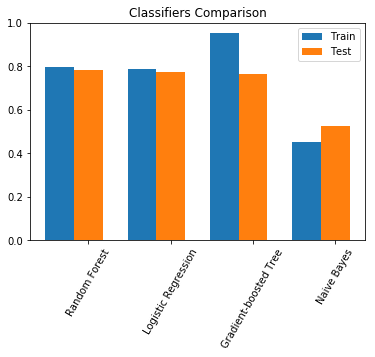

In [68]:
# plot the results to compare models

fig, ax = plt.subplots()
ax.set_title('Classifiers Comparison')

width = 0.35

x_pos = np.arange(0, 4)

p1 = ax.bar(x_pos, [rf_train, lr_train, gbt_train, nb_train], width,\
            tick_label = ['Random Forest', 'Logistic Regression', 'Gradient-boosted Tree', 'Naive Bayes'])
p2 = ax.bar(x_pos + width, [rf_test, lr_test, gbt_test, nb_test], width, \
                 tick_label = ['Random Forest', 'Logistic Regression', 'Gradient-boosted Tree', 'Naive Bayes'])

ax.legend((p1[0], p2[0]), ('Train', 'Test'))

for tick in ax.get_xticklabels():
    tick.set_rotation(60)

plt.plot()

## Refinement

To increase F1 scores, we can take the following refinement measures:
* Add preprocessing to the pipeline: add scaling or normalization to preprocess numeric features.
* Refine `last_state` column values: introduce categorical value ‘other’ for rare states.
* Bucketize `avg_songs` and `avg_events` columns.

### Add preprocessing of features:

Define framework for model comparison:

In [78]:
def evaluate_model(pipeline, train, test):
    '''
    Function which evaluates the model and returns f1 score for train and test sets
    INPUTS:
        1. pipeline - machine learning pipeline
        2. train - train dataset
        3. test - test dataset
        
    OUTPUTS:
        1. f1_train - f1 score for train set
        2. f1_test - f1 score for test set
    '''
    
    model = pipeline.fit(train)
     
    # get predictions
    pred_train = model.transform(train)
    pred_test = model.transform(test)
    
    # get metrics for train
    predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
    metrics = MulticlassMetrics(predictionAndLabels)

    f1_train = metrics.fMeasure()
    
    # get metrics for test
    predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))
    metrics = MulticlassMetrics(predictionAndLabels)

    f1_test = metrics.fMeasure()
    
    return f1_train, f1_test

In [79]:
def compare_models(stages, classifiers, train, test):
    '''
    Function to compare classifiers
    INPUTS:
        1. stages - list of pipeline stages
        2. classifiers - dictionary of classifiers
        3. train - train dataset
        4. test - test dataset
        
    OUTPUT:
        1. f1_scores - pandas dataframe with f1 scores for each classifier
        for test and train datasets
    '''
    
    f1_scores = pd.DataFrame()
    
    # for each classifier in list
    for classifier_key in classifiers.keys():
        
        # assemble pipeline
        stages_cl = stages.copy()
        stages_cl.append(classifiers[classifier_key])
        
        print(stages_cl)
        
        pipeline = Pipeline(stages = stages_cl)
        
        # get f1 scores for train and test
        f1_train, f1_test = evaluate_model(pipeline, train, test)
        
        # append to dataframe
        f1_scores = f1_scores.append({'classifier': classifier_key, 'train': f1_train, 'test': f1_test}\
                                     , ignore_index=True)
        
    return f1_scores

In [80]:
def plot_model_comparison(title, f1_scores):
    '''
    Function plots bar chart with f1 scores
    INPUTS:
        1. title - plot title
        2. f1_scores - pandas dataframe with f1 scores for each classifier
        for test and train datasets
        
    OUTPUT:
        None, the function plots bar chart with f1 scores for train and test
    '''
    
    fig, ax = plt.subplots()
    ax.set_title(title)

    width = 0.35

    x_pos = np.arange(0, 4)

    p1 = ax.bar(x_pos, f1_scores['train'].values, width,\
            tick_label = f1_scores['classifier'].values)
    p2 = ax.bar(x_pos + width, f1_scores['test'].values, width, \
                 tick_label = f1_scores['classifier'].values)

    ax.legend((p1[0], p2[0]), ('Train', 'Test'))

    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

    plt.plot()

Use functions defined above to compare different algorithms:

In [10]:
df_ml = df_ml.withColumnRenamed("churn", "label")

# split dataset
train, test, valid = df_ml.randomSplit([0.6, 0.2, 0.2])

In [11]:
#create stages

stringIndexerGender = StringIndexer(inputCol="gender", outputCol="genderIndex", handleInvalid = 'skip')
stringIndexerLevel = StringIndexer(inputCol="last_level", outputCol="levelIndex", handleInvalid = 'skip')
stringIndexerState = StringIndexer(inputCol="last_state", outputCol="stateIndex", handleInvalid = 'skip')

encoder = OneHotEncoderEstimator(inputCols=["genderIndex", "levelIndex", "stateIndex"],
                                       outputCols=["genderVec", "levelVec", "stateVec"],
                                handleInvalid = 'keep')

# create vector for features
features = ['genderVec', 'levelVec', 'stateVec', 'days_active', 'avg_songs', 'avg_events', 'thumbs_up', 'thumbs_down', 'addfriend']
assembler = VectorAssembler(inputCols=features, outputCol="features")

stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler]

In [12]:
# initialize classifiers

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# create dictionary

classifiers = {'Random Forest': rf, 'Logistic Regression' : lr, 'Gradient-boosted Tree' : gbt, 'Naive Bayes' : nb}

In [84]:
# calculate f1 scores
f1_scores = compare_models(stages, classifiers, train, test)

[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_c666fce1f754, RandomForestClassifier_33c20388a91f]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_c666fce1f754, LogisticRegression_a1a4b8a1ae02]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_c666fce1f754, GBTClassifier_8639e453de8d]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_c666fce1f754, NaiveBayes_d67dc8de5a8c]


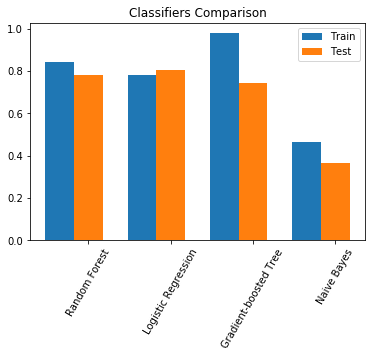

In [85]:
# plot results
plot_model_comparison('Classifiers Comparison', f1_scores)

In [92]:
f1_scores

,classifier,test,train
0,Random Forest,0.780488,0.841328
1,Logistic Regression,0.804878,0.782288
2,Gradient-boosted Tree,0.743902,0.977860
3,Naive Bayes,0.365854,0.464945


`1`  Add scaling as preprocessing:

In [86]:
# add scaler
assembler = VectorAssembler(inputCols=features, outputCol="rawFeatures")
scaler = MinMaxScaler(inputCol="rawFeatures", outputCol="features")

stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, scaler]

In [87]:
# calculate f1 scores
f1_scores_scaling = compare_models(stages, classifiers, train, test)

[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_83e54155f1ab, MinMaxScaler_88e115a7c388, RandomForestClassifier_33c20388a91f]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_83e54155f1ab, MinMaxScaler_88e115a7c388, LogisticRegression_a1a4b8a1ae02]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_83e54155f1ab, MinMaxScaler_88e115a7c388, GBTClassifier_8639e453de8d]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_83e54155f1ab, MinMaxScaler_88e115a7c388, NaiveBayes_d67dc8de5a8c]


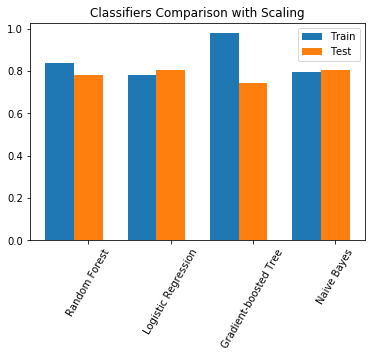

In [88]:
# plot results
plot_model_comparison('Classifiers Comparison with Scaling', f1_scores_scaling)

In [93]:
f1_scores_scaling

,classifier,test,train
0,Random Forest,0.780488,0.837638
1,Logistic Regression,0.804878,0.782288
2,Gradient-boosted Tree,0.743902,0.977860
3,Naive Bayes,0.804878,0.793358


`2` Add normalization as preprocessing:

In [89]:
# add normalizer
assembler = VectorAssembler(inputCols=features, outputCol="rawFeatures")
normalizer = Normalizer(inputCol="rawFeatures", outputCol="features", p=1.0)

stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, normalizer]

In [90]:
# calculate f1 scores
f1_scores_norm = compare_models(stages, classifiers, train, test)

[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_0f38495907b4, Normalizer_6ba2297486c8, RandomForestClassifier_33c20388a91f]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_0f38495907b4, Normalizer_6ba2297486c8, LogisticRegression_a1a4b8a1ae02]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_0f38495907b4, Normalizer_6ba2297486c8, GBTClassifier_8639e453de8d]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_0f38495907b4, Normalizer_6ba2297486c8, NaiveBayes_d67dc8de5a8c]


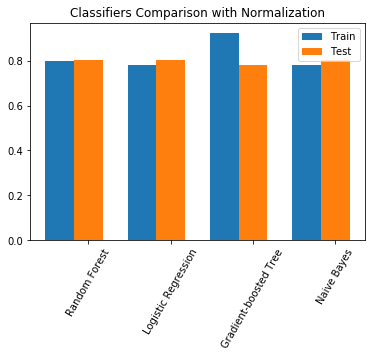

In [91]:
# plot results
plot_model_comparison('Classifiers Comparison with Normalization', f1_scores_norm)

In [94]:
f1_scores_norm

,classifier,test,train
0,Random Forest,0.804878,0.800738
1,Logistic Regression,0.804878,0.782288
2,Gradient-boosted Tree,0.780488,0.922509
3,Naive Bayes,0.804878,0.782288


#### Conclusions:

Preprocessing increases slightly F1 scores of Random Forest and Gradient-boosted Tree algorithms and dramatically increases scores of Naïve Bayes algorithm.

### Refine `last_level` feature: set value 'other' for rare states

Rewrite `prepare_dataset` function to set value 'other' for rare states instead of postal codes:

In [6]:
def prepare_dataset_refined(df):
    '''
    Function for preparation of dataset for machine learning
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning
    contains the following columns:
    1. userId - initial id of the user
    2. gender - user's gender
    3. avg_events - average number of events per day for the user
    4. avg_songs - average number of songs the user listens to per day
    5. thumbs_up - number of thumbs up events
    6. thumbs_down - number of thumbs down events
    7. active_days - days since user's firts event
    8. last_location - location of the last event
    9. last_level - user's last level (paid or free)
    10. addfriends - number of add friends events
    '''
    
    # clean dataset using clean_data function
    df = clean_data(df)
    
    # add 'churn' column to the original dataset
    
    # define cancellation udf
    cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    
    # set churn = 1 for rows where page == 'Cancellation Confirmation'
    df = df.withColumn("churn", cancellation_event("page"))
    
    # get userId with churn == 1
    cancelled_users = df.select(['userId']).where(df.churn == 1).groupby('userId').count().toPandas()['userId'].values
    
    # create udf, which sets churn of a row to 1 if userId is in cancelled_users list
    def fill_array(userId, features):
        if(userId in cancelled_users): return 1
        else : return 0
    
    # set churn == 1 for all rows for users who cancelled their subscription
    fill_array_udf = udf(fill_array, IntegerType())
    df = df.withColumn("churn", fill_array_udf(col("userId"), col("churn")))
    
    # set column last ts with the first and the last event timestamp
    w = Window.partitionBy('userId')
    df = df.withColumn('last_ts', max('ts').over(w))
    df = df.withColumn('first_ts', min('ts').over(w))
    
    # convert timestamp to date (string)
    def get_date_from_ts(ts):
        return str(datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d'))
    
    get_date_from_ts_udf = udf(get_date_from_ts, StringType())
    df = df.withColumn('last_date', get_date_from_ts_udf(col('last_ts')))
    df = df.withColumn('first_date', get_date_from_ts_udf(col('first_ts')))
    
    # add column date and convert timetamp to date
    df = df.withColumn('date', get_date_from_ts_udf(col('ts')))
    
    # set column last_level to level when timestamp is last timestamp
    df = df.withColumn('last_level',when(df.last_ts == df.ts, df.level))
    
    # create column avg_songs to calculate average number of songs per day
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs', avg('songs').over(w))
    songs = songs.select(col("userId").alias("songs_userId"), 'avg_songs')
    songs = songs.withColumn("avg_songs", round(songs["avg_songs"], 2))
    
    # create column avg_songs to calculate average number of events per day
    w = Window.partitionBy('userId', 'date')
    events = df.select('userId', 'date', count('userId').over(w).alias('events')).distinct()
    w = Window.partitionBy('userId')
    events = events.withColumn('avg_events', avg('events').over(w))
    events = events.select(col("userId").alias("events_userId"), 'avg_events')
    events = events.withColumn("avg_events", round(events["avg_events"], 2))
    
    # calculate number of thumbs up for a user
    w = Window.partitionBy('userId')
    thumbsup = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbsup = thumbsup.select(col("userId").alias("thumbsup_userId"), 'thumbs_up')
    
    # calculate number of thumbs down for a user
    w = Window.partitionBy('userId')
    thumbsdown = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbsdown = thumbsdown.select(col("userId").alias("thumbsdown_userId"), 'thumbs_down')
    
    # calculate days since the date of the first event
    df = df.withColumn("days_active", 
              datediff(to_date(lit(datetime.now().strftime("%Y-%m-%d %H:%M"))),
                       to_date("first_date","yyyy-MM-dd")))
    
    # add column with state of the event based on location column
    def get_state(location):
        location = location.split(',')[-1].strip()
        if (len(location) > 2):
            location = location.split('-')[-1].strip()
    
        return location
    
    get_state_udf = udf(get_state, StringType())
    df = df.withColumn('state', get_state_udf(col('location')))
    
    #add column with last location of the user
    df = df.withColumn('last_state',when(df.last_ts == df.ts, df.state))
    
    # find top states
    top_states = df.select('last_state').groupBy(df.last_state).count().sort(col("count").desc()).limit(11).toPandas()
    top_states_list = top_states['last_state'][1:].values.tolist()
    
    # change names of rare states to 'OTHER'
    df = df.withColumn('last_state',when(df.last_state.isin(top_states_list), df.last_state).otherwise('OTHER'))
    
    # calculate number of add friends for a user
    w = Window.partitionBy('userId')
    addfriend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('addfriend')).distinct()
    addfriend = addfriend.select(col("userId").alias("addfriend_userId"), 'addfriend')

    # assemble everything into resulting dataset
    df_ml = df.select('userId', 'gender', 'churn', 'last_level', 'days_active', 'last_state')\
    .dropna().drop_duplicates()
    df_ml = df_ml.join(songs, df_ml.userId == songs.songs_userId).distinct()
    df_ml = df_ml.join(events, df_ml.userId == events.events_userId).distinct()
    df_ml = df_ml.join(thumbsup, df_ml.userId == thumbsup.thumbsup_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_up'])
    df_ml = df_ml.join(thumbsdown, df_ml.userId == thumbsdown.thumbsdown_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_down'])
    df_ml = df_ml.join(addfriend, df_ml.userId == addfriend.addfriend_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['addfriend'])
    df_ml = df_ml.drop('songs_userId','events_userId', 'thumbsup_userId', 'thumbsdown_userId', 'addfriend_userId')
    
    return df, df_ml

Apply the function to dataset, ensure that the function works as assumed:

In [7]:
df, df_ml = prepare_dataset_refined(df)

In [8]:
df.head()

Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=1, last_ts=1539254318000, first_ts=1538991392000, last_date='2018-10-11', first_date='2018-10-08', date='2018-10-08', last_level=None, days_active=190, state='CT', last_state='OTHER')

In [9]:
df_ml.show()

+------+------+-----+----------+-----------+----------+---------+----------+---------+-----------+---------+
|userId|gender|churn|last_level|days_active|last_state|avg_songs|avg_events|thumbs_up|thumbs_down|addfriend|
+------+------+-----+----------+-----------+----------+---------+----------+---------+-----------+---------+
|100010|     F|    1|      free|        190|     OTHER|     48.0|      68.5|        4|          3|        3|
|200002|     M|    1|      paid|        197|        WI|    51.67|     65.83|       15|          5|        2|
|   296|     F|    1|      paid|        196|     OTHER|     22.4|      30.4|        8|          0|        2|
|   125|     M|    0|      free|        196|        TX|    20.67|      28.0|        3|          1|        3|
|   124|     F|    1|      paid|        197|     OTHER|    86.95|      98.0|      102|         15|       26|
|    51|     M|    1|      paid|        197|     OTHER|    44.33|     54.67|       16|          1|        3|
|     7|     M|    

In [118]:
df_ml.select('last_state').distinct().show()

+----------+
|last_state|
+----------+
|        SC|
|        WI|
|        CA|
|        NC|
|        MD|
|        WA|
|        IN|
|        PA|
|     OTHER|
|        TX|
|        FL|
+----------+



In [119]:
df_ml.count()

448

Check F1 scores for dataset with refined `'last_state'` values:

In [120]:
df_ml = df_ml.withColumnRenamed("churn", "label")

# split dataset
train, test, valid = df_ml.randomSplit([0.6, 0.2, 0.2])

In [121]:
# assemble pipeline

assembler = VectorAssembler(inputCols=features, outputCol="features")
stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler]

In [122]:
# calculate f1 scores
f1_scores_refined_state = compare_models(stages, classifiers, train, test)

[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_41b83e5903ba, RandomForestClassifier_33c20388a91f]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_41b83e5903ba, LogisticRegression_a1a4b8a1ae02]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_41b83e5903ba, GBTClassifier_8639e453de8d]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_41b83e5903ba, NaiveBayes_d67dc8de5a8c]


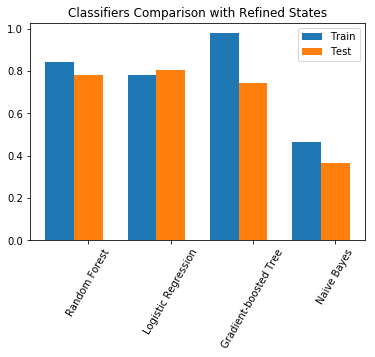

In [124]:
# plot results
plot_model_comparison('Classifiers Comparison with Refined States', f1_scores)

In [125]:
f1_scores_refined_state

,classifier,test,train
0,Random Forest,0.792208,0.822222
1,Logistic Regression,0.792208,0.800000
2,Gradient-boosted Tree,0.727273,0.951852
3,Naive Bayes,0.610390,0.666667


#### Conclusions

We can see that refining the location feature helps to improve scores for some algorithms.

### Bucketize `avg_songs` and `avg_events` 

View distribution of `avg_songs` and `avg_events` values to find out buckets to bucketize features:

In [130]:
events = df_ml.select('avg_songs', 'avg_events').toPandas()

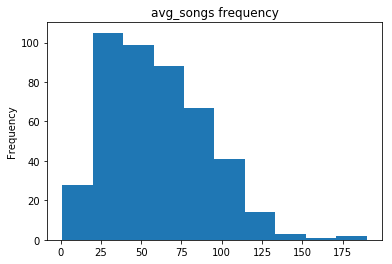

In [137]:
events['avg_songs'].plot.hist(title = 'avg_songs frequency')

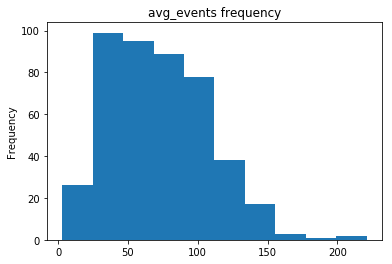

In [138]:
events['avg_events'].plot.hist(title = 'avg_events frequency')

In [147]:
# add bucketizers

songs_bucketizer = Bucketizer(splits=[ 0, 25, 50, 75, 100, 125, float('Inf') ],inputCol="avg_songs", outputCol="songs_buckets", handleInvalid = 'keep')
events_bucketizer = Bucketizer(splits=[ 0, 25, 50, 100, 150, float('Inf') ],inputCol="avg_events", outputCol="events_buckets", handleInvalid = 'keep')

# create vector for features
features = ['genderVec', 'levelVec', 'stateVec', 'days_active', 'songs_buckets', 'events_buckets', 'thumbs_up', 'thumbs_down', 'addfriend']
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [142]:
# assemble pipeline

stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder\
          , songs_bucketizer, events_bucketizer, assembler]

In [143]:
# initialize classifiers

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# create dictionary

classifiers = {'Random Forest': rf, 'Logistic Regression' : lr, 'Gradient-boosted Tree' : gbt, 'Naive Bayes' : nb}

In [148]:
# calculate f1 scores
f1_scores_buckets = compare_models(stages, classifiers, train, test)

[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, Bucketizer_e13908ad694e, Bucketizer_e23a8e10aa49, VectorAssembler_5c5514d7489a, RandomForestClassifier_06c46fb9688b]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, Bucketizer_e13908ad694e, Bucketizer_e23a8e10aa49, VectorAssembler_5c5514d7489a, LogisticRegression_7abd99efa2de]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, Bucketizer_e13908ad694e, Bucketizer_e23a8e10aa49, VectorAssembler_5c5514d7489a, GBTClassifier_7ebc129a8269]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, Bucketizer_e13908ad694e, Bucketizer_e23a8e10aa49, VectorAssembler_5c5514d7489a, NaiveBayes_d2677d9fd43a]


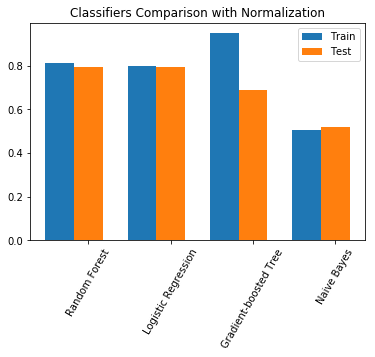

In [149]:
# plot results
plot_model_comparison('Classifiers Comparison with Normalization', f1_scores_buckets)

In [150]:
f1_scores_buckets

,classifier,test,train
0,Random Forest,0.792208,0.811111
1,Logistic Regression,0.792208,0.800000
2,Gradient-boosted Tree,0.688312,0.948148
3,Naive Bayes,0.519481,0.503704


#### Conclusions

Bucketizing has no effect on the F1 score, so I won't include bucketizing in the final model.

### Combine Refinement Approaches

In [13]:
# add normalizer
features = ['genderVec', 'levelVec', 'stateVec', 'days_active', 'avg_songs', 'avg_events', 'thumbs_up', 'thumbs_down', 'addfriend']
assembler = VectorAssembler(inputCols=features, outputCol="rawFeatures")
normalizer = Normalizer(inputCol="rawFeatures", outputCol="features", p=1.0)

stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, normalizer]

In [156]:
# calculate f1 scores
f1_scores_norm_refined = compare_models(stages, classifiers, train, test)

[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_de936a698610, Normalizer_da6161589199, RandomForestClassifier_06c46fb9688b]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_de936a698610, Normalizer_da6161589199, LogisticRegression_7abd99efa2de]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_de936a698610, Normalizer_da6161589199, GBTClassifier_7ebc129a8269]
[StringIndexer_f4ad95db6594, StringIndexer_0a830a182e19, StringIndexer_b1f60f6160ca, OneHotEncoderEstimator_43048b6bf185, VectorAssembler_de936a698610, Normalizer_da6161589199, NaiveBayes_d2677d9fd43a]


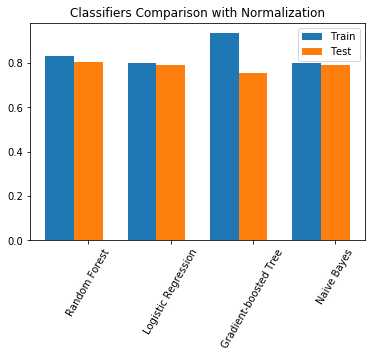

In [157]:
# plot results
plot_model_comparison('Classifiers Comparison with Normalization', f1_scores_norm_refined)

In [158]:
f1_scores_norm_refined

,classifier,test,train
0,Random Forest,0.805195,0.829630
1,Logistic Regression,0.792208,0.800000
2,Gradient-boosted Tree,0.753247,0.933333
3,Naive Bayes,0.792208,0.800000


## Refinement Conclusion

As we see above the most effective measures for model refinement are <b> normalization of numeric features and the additional preprocessing of location feature </b>. Bucketizing of numerical values didn't help to increase scores.
In conclusion I can say that the combination of the refinement measures taken above helped to <b>improve the final scores by 2-3% </b>.

## Final Model Evaluation

For the final model I chose Random Forest algorithm, because it showed the best performance.
<br> Let's tune the parameters for this algorithm:

In [17]:
# assemble the resulting pipeline

stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, normalizer, rf]
pipeline = Pipeline(stages = stages)

In [18]:
# initialize the parameter grid

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [2, 3, 5]) \
    .addGrid(rf.impurity, ['entropy', 'gini'])\
    .addGrid(rf.featureSubsetStrategy, ['auto','sqrt', 'log2'])\
    .build()

In [19]:
# initialize the cross validator instance

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [20]:
# perform cross validation

cvModel = crossval.fit(train)
bestModel = cvModel.bestModel

In [21]:
# get the results of cross validation

# get parameters
params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

# convert validation results to pandas dataframe
validation_results = pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

In [22]:
validation_results

,f1,featureSubsetStrategy,impurity,maxDepth,numTrees
0,0.669582,auto,entropy,2,10
1,0.669582,sqrt,entropy,2,10
2,0.669582,log2,entropy,2,10
3,0.669582,auto,gini,2,10
4,0.669582,sqrt,gini,2,10
5,0.669582,log2,gini,2,10
6,0.669582,auto,entropy,3,10
7,0.669582,sqrt,entropy,3,10
8,0.669582,log2,entropy,3,10
9,0.669582,auto,gini,3,10


Best model score:

In [37]:
# initialize RF with best parameters
rf_tuned = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth = 5,\
                                 impurity = 'gini', featureSubsetStrategy = 'sqrt')

# assemble pipeline
stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, normalizer, rf_tuned]
pipeline_tuned = Pipeline(stages = stages)

# fit model
pipeline_tuned.fit(train)

# get predictions for train, test, and validation datasets
best_pred_train = bestModel.transform(train)
best_pred_test = bestModel.transform(test)
best_pred_valid = bestModel.transform(valid)

In [38]:
predictionAndLabels = best_pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics_train = MulticlassMetrics(predictionAndLabels)

f1_train = metrics_train.fMeasure()

# F1 score
print("F1 score on train dataset is %s" % metrics_train.fMeasure())

F1 score on train dataset is 0.8231046931407943


In [39]:
predictionAndLabels = best_pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics_test = MulticlassMetrics(predictionAndLabels)

f1_test = metrics_test.fMeasure()

# F1 score
print("F1 score on test dataset is %s" % metrics_test.fMeasure())

F1 score on test dataset is 0.7864077669902912


In [40]:
predictionAndLabels = best_pred_valid.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics_valid = MulticlassMetrics(predictionAndLabels)

f1_valid = metrics_valid.fMeasure()

# F1 score
print("F1 score on validation dataset is %s" % metrics_valid.fMeasure())

F1 score on validation dataset is 0.8088235294117647


## Conclusion

To predict customer churn there was built a machine learning pipeline which consist of:
* the indexers and an encoder for categorical features,
* the feature assembler,
* the normalizer for numeric features,
* the Random Forest Classifier.

The Random Forest Classifier was chosen from set of other models because it demonstrated the best performance in terms of the F1 score.

<br> For the final model the best hyperparameters for the Random Forest Classifier were chosen using the cross validation approach. The best model's scores are:
* 82% F1 score on train dataset,
* 78% F1 score on test dataset,
* and 81% F1 score on validation dataset.

<br> We achieved robust solution, because the model generalizes well to the new validation dataset. The difference between train and validation scores is about 1%.

### Justification

These are the main characteristics of the final solution:
* Spark (PySpark and SparkML libraries) was used to analyze data and make predictions. 
* The solution is based on dataset, which contains the following extracted features for each user: gender, last user level , the number of days since registration, last location, the average number of events and songs listened per day, the number of thumbs up events, the number of thumbs down events, the number of add friend action events.
* Categorical features (last level, last location, gender) are transformed into dummy variables.
* Numerical features are normalized. Normalization improved scores Gradient-boosted Tree Classifier because without normalization some weights update much faster than others in case of using gradient descent/ascent-based optimization. Normalization also improved scores of Naive Bayes, because this algorithm is sensitive to distances between points.
* In the final model Random Forest Classifier was used to predict churn. This classifier performs best in our case because this method is good at handling categorical variables and is resistant to overfitting. The final model has 81% F1 score on the validation dataset.
* The flask web application was built to demonstrate the working model. Flask was chosen because it allows building a rapid solution in Python.